In [1]:

import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

### <p style="font-family: Arial; color: gold; font-weight: bold;"> define your input and output folders below

In [2]:
input_common_structure_folder = "1.common_structure copy"

# spreadsheet with SMILES and names
input_smiles_spreadsheet = "smiles.xlsx"
# column headers for SMILES and origin ids
origin_SMILES_header = "SMILES"
origin_naming_header = "id"
# put all you files here (.sdf, .com, .log)
input_files_folder = "1.files"

output_folder = "1.renamed_files"

Below are all the common structures and their prefixes (unordered):


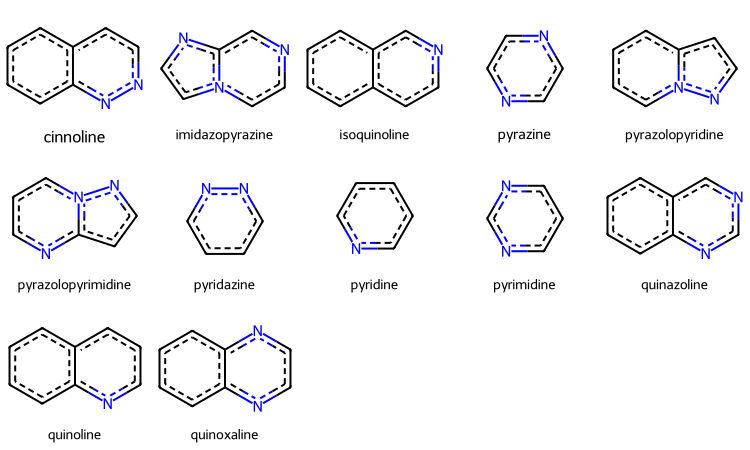

In [3]:
# we have to map to their corresponding core structures
common_structure_list = {}
# grep all the cdxml files in the common structure folder
for file in glob.glob("*.cdxml", root_dir=input_common_structure_folder):
    # get the filename without the extension, we will use it as the prefix
    key = file.split(".")[0]
    substructure = Chem.MolsFromCDXMLFile(os.path.join(input_common_structure_folder, file))
    # output to Smarts format
    temp_smarts = Chem.MolToSmarts(substructure[0])
    # reparse the Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure
common_structure_prefix = list(common_structure_list.keys())


def print_common_structure_list(common_structure_list):
    # Prepare the list of molecules and corresponding legends (for display under each molecule)
    mols = list(common_structure_list.values())
    legends = list(common_structure_list.keys())
    # Generate a grid image with a fixed number of columns (5 columns)
    img = Chem.Draw.MolsToGridImage(
        mols, molsPerRow=5, subImgSize=(150, 150), legends=legends
    )
    display(img)  # Display the grid of images

print(f"Below are all the common structures and their prefixes (unordered):")
print_common_structure_list(common_structure_list)

In [4]:
# You could manual reorder the list of common structures to match complex structures first.
print("Reorder the list of common structures according to your preference:")
print(f"Current order: {common_structure_prefix}")

Reorder the list of common structures according to your preference:
Current order: ['cinnoline', 'imidazopyrazine', 'isoquinoline', 'pyrazine', 'pyrazolopyridine', 'pyrazolopyrimidine', 'pyridazine', 'pyridine', 'pyrimidine', 'quinazoline', 'quinoline', 'quinoxaline']


### <p style="font-family: Arial; color: gold; font-weight: bold;"> Reorder the list of common structures according to your preference. The structure at the front will matched first and once match, subsequent structures will not be matched.
##### <p style="font-family: Arial; color: gold; font-weight: bold;"> This solve the problem when we have, for example, pyridine and quinoline in the same dataset and we want to distinguish between them. <br>By setting quinoline before pyridine in the list, if a compound has quinoline structure, it will be first matched to quinoline and pyridine will not be matched. <br>But those with pyridine in the name will be matched to pyridine.

Below are all the common structures and their prefixes (reordered):


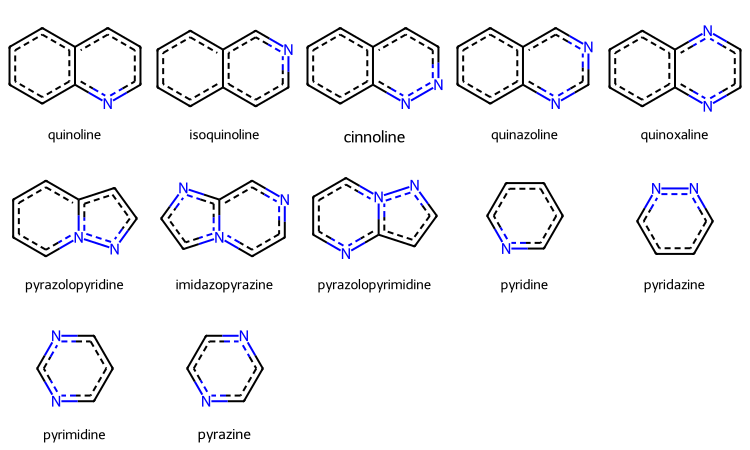

In [5]:
new_common_structure_prefix = [
    # 6 + 6 fused rings
    "quinoline",
    "isoquinoline",
    "cinnoline",
    "quinazoline",
    "quinoxaline",
    # 6 + 5 fused rings
    "pyrazolopyridine",
    "imidazopyrazine",
    "pyrazolopyrimidine",
    # single ring
    "pyridine",
    "pyridazine",
    "pyrimidine",
    "pyrazine",
]
# resort the common_structure_list
# use the reordered list to resort the dictionary
common_structure_list = {
    prefix: common_structure_list[prefix] for prefix in new_common_structure_prefix
}
print(f"Below are all the common structures and their prefixes (reordered):")
print_common_structure_list(common_structure_list)

In [6]:
# load an excel file name smiles.xlsx
df = pd.read_excel(input_smiles_spreadsheet)
# use RDKit convert SMILES to mol object, make a dict with id as key and mol object as value
mols = {}
for i, row in df.iterrows():
    # print(f"SMILES: {row[origin_SMILES_header]}, id: {row[origin_naming_header]}")
    mols[row[origin_naming_header]] = Chem.MolFromSmiles(row[origin_SMILES_header])

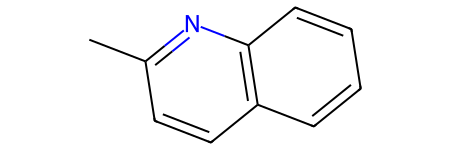

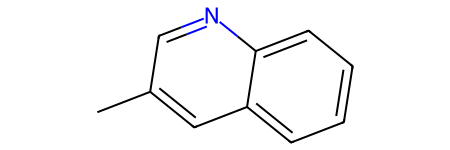

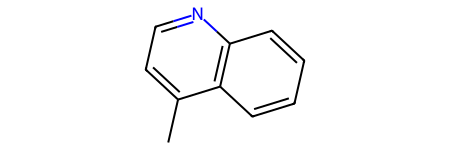

In [7]:
# display the first 3 molecules
for i, (id, mol) in enumerate(mols.items()):
    if i >= 3:
        break
    display(mol)

In [8]:
# now attempt to match all common structures to each molecule, and if we find a match, we will store into a mapping from original id to new prefix
# use GetSubstructMatches
mapping = {}
# used for drawing the molecules
molsMatrix = {}
legendsMatrix = {}
highlightAtomListsMatrix = {}
for id, mol in mols.items():
    print("----------------------------------")
    for key, substructure in common_structure_list.items():
        substructure_matches = mol.GetSubstructMatches(substructure)
        if len(substructure_matches) > 0:
            # first check if this id is already in the mapping
            if id in mapping:
                print(f"Warning: {id} already match with {mapping[id]}, will NOT match to {key}!")
            else:
                print(f"{id} matches {key}")
                mapping[id] = key
                highlightAtomLists = list([item for sublist in substructure_matches for item in sublist])
                if key in molsMatrix:
                    molsMatrix[key].append(mol)
                else:
                    molsMatrix[key] = [mol]
                if key in legendsMatrix:
                    legendsMatrix[key].append(id)
                else:
                    legendsMatrix[key] = [id]
                if key in highlightAtomListsMatrix:
                    highlightAtomListsMatrix[key].append(highlightAtomLists)
                else:
                    highlightAtomListsMatrix[key] = [highlightAtomLists]

        # warn if we have multiple matches
        if len(substructure_matches) > 1:
            print(f"Warning: {id} has multiple matches to {key}!!!!!! Manually check the substructure!")

----------------------------------
Het001 matches quinoline
----------------------------------
Het002 matches quinoline
----------------------------------
Het003 matches quinoline
----------------------------------
Het004 matches quinazoline
----------------------------------
Het005 matches quinazoline
----------------------------------
Het006 matches quinoxaline
----------------------------------
Het007 matches isoquinoline
----------------------------------
Het008 matches isoquinoline
----------------------------------
Het009 matches isoquinoline
----------------------------------
Het010 matches quinoline
----------------------------------
Het011 matches quinoline
----------------------------------
Het012 matches quinoline
----------------------------------
Het013 matches quinazoline
----------------------------------
Het014 matches quinazoline
----------------------------------
Het015 matches quinoxaline
----------------------------------
Het016 matches isoquinoline
----------------

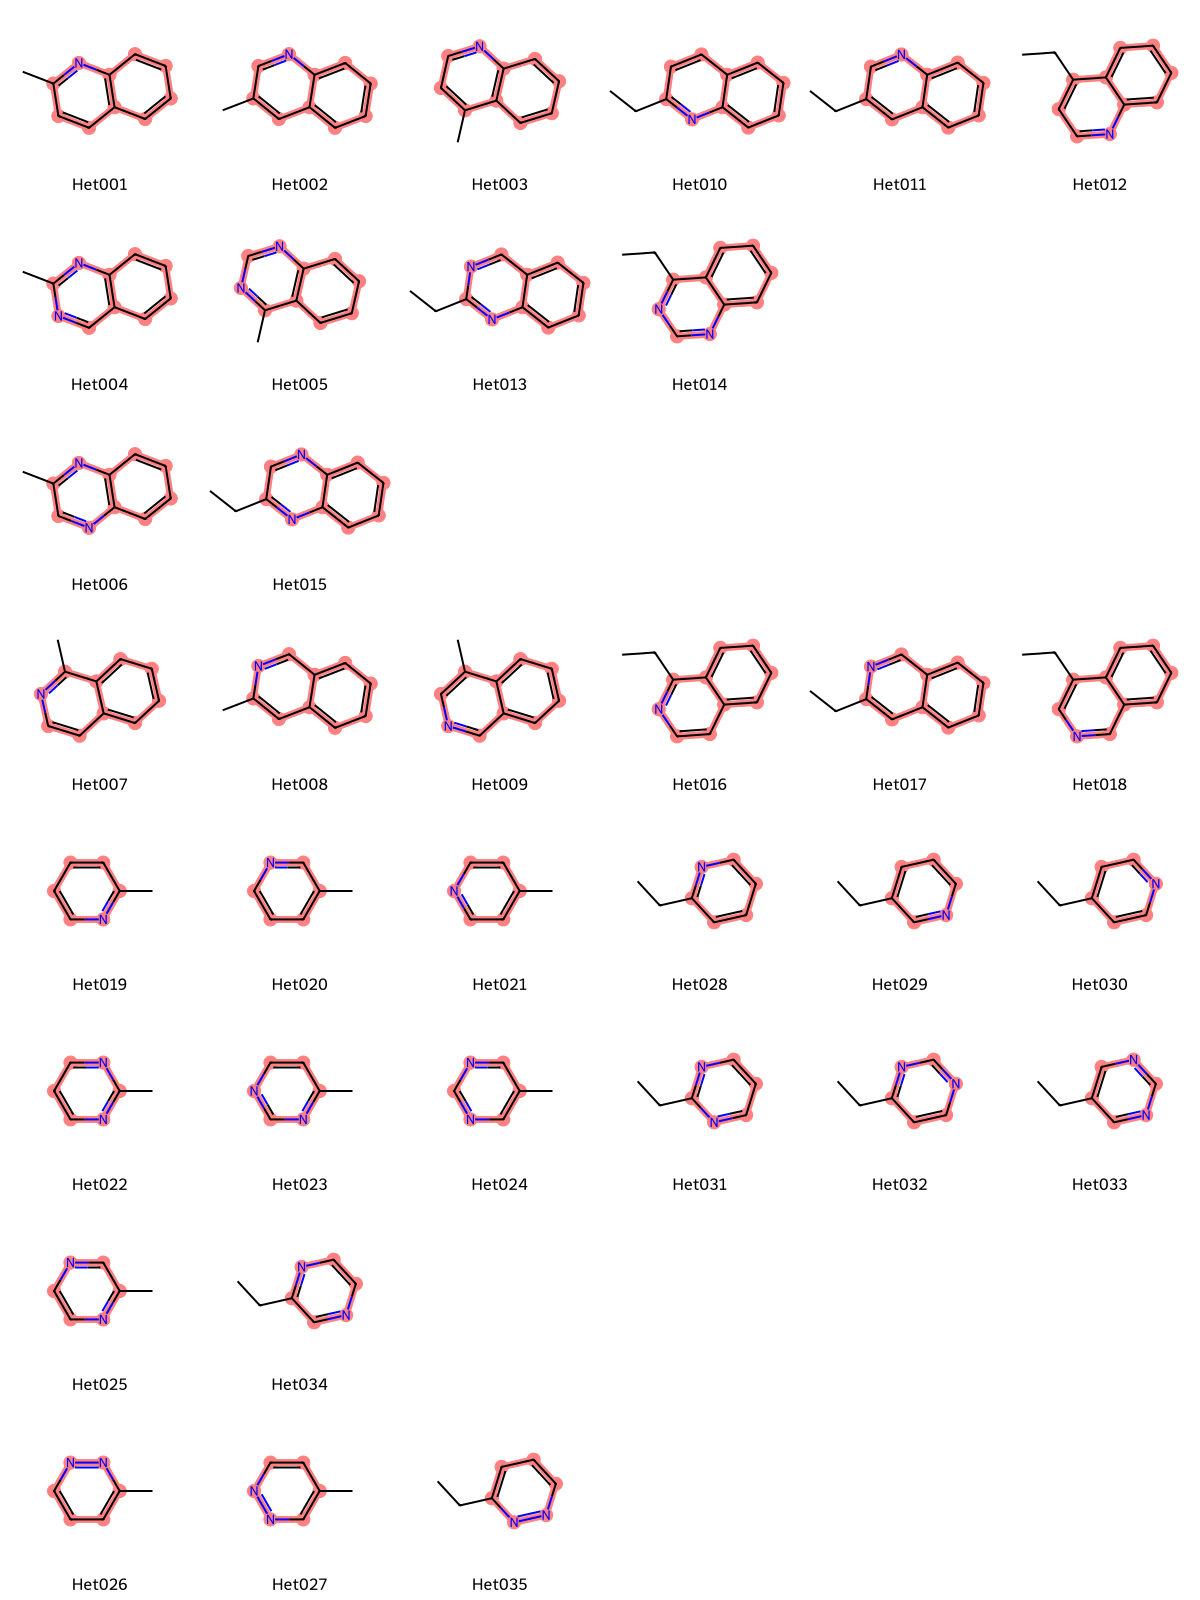

In [9]:
# display all images in a grid with a caption showing the id and highlighted the matched substructure using MolsToGridImage
Chem.Draw.MolsMatrixToGridImage(
    molsMatrix = list(molsMatrix.values()),
    subImgSize=(200, 200),
    # legendsMatrix: A two-deep nested data structure of strings to label molecules with, iterable of iterables (for example list of lists) of strings (default None)
    legendsMatrix = list(legendsMatrix.values()),
    # highlightAtomListsMatrix: A three-deep nested data structure of integers of atoms to highlight, iterable of iterables (for example list of lists) of integers (default None)
    highlightAtomListsMatrix = list(highlightAtomListsMatrix.values()),
)

### <p style="font-family: Arial; color: gold; font-weight: bold;"> A Upgraded version of drawing out all the molecules with matching structures highlighted, save individual images into a folder name **molecule_images**

In [10]:
# Create output directory
output_dir = "molecule_images"
os.makedirs(output_dir, exist_ok=True)
# delete everything in the output directory
for file in glob.glob("*", root_dir=output_dir):
    os.remove(os.path.join(output_dir, file))


# Function to draw and save molecule
def draw_and_save_molecule(mol, matcheslist, id, group):
    drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(600, 600)
    drawer.drawOptions().comicMode = True
    drawer.drawOptions().addAtomIndices = True
    drawer.drawOptions().continuousHighlight = True
    # adjust the font size
    drawer.drawOptions().baseFontSize = 1
    drawer.drawOptions().bondLineWidth = 5
    drawer.drawOptions().highlightRadius = 0.35
    drawer.drawOptions().highlightBondWidthMultiplier = 3
    highlight_colors = {
        atom: ColorConverter().to_rgba("Salmon", alpha=0.8) for atom in matcheslist
    }
    drawer.DrawMolecule(
        mol, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors
    )
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()
    with open(os.path.join(output_dir, f"{group}_{id}.png"), "wb") as f:
        f.write(img)


# Draw and save images for each group
for group, molecules in molsMatrix.items():
    for i, mol in enumerate(molecules):
        id = legendsMatrix[group][i]
        matcheslist = highlightAtomListsMatrix[group][i]
        draw_and_save_molecule(mol, matcheslist, id, group)

C:\Users\R9000P\AppData\Local\Temp\ipykernel_51180\2541515240.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


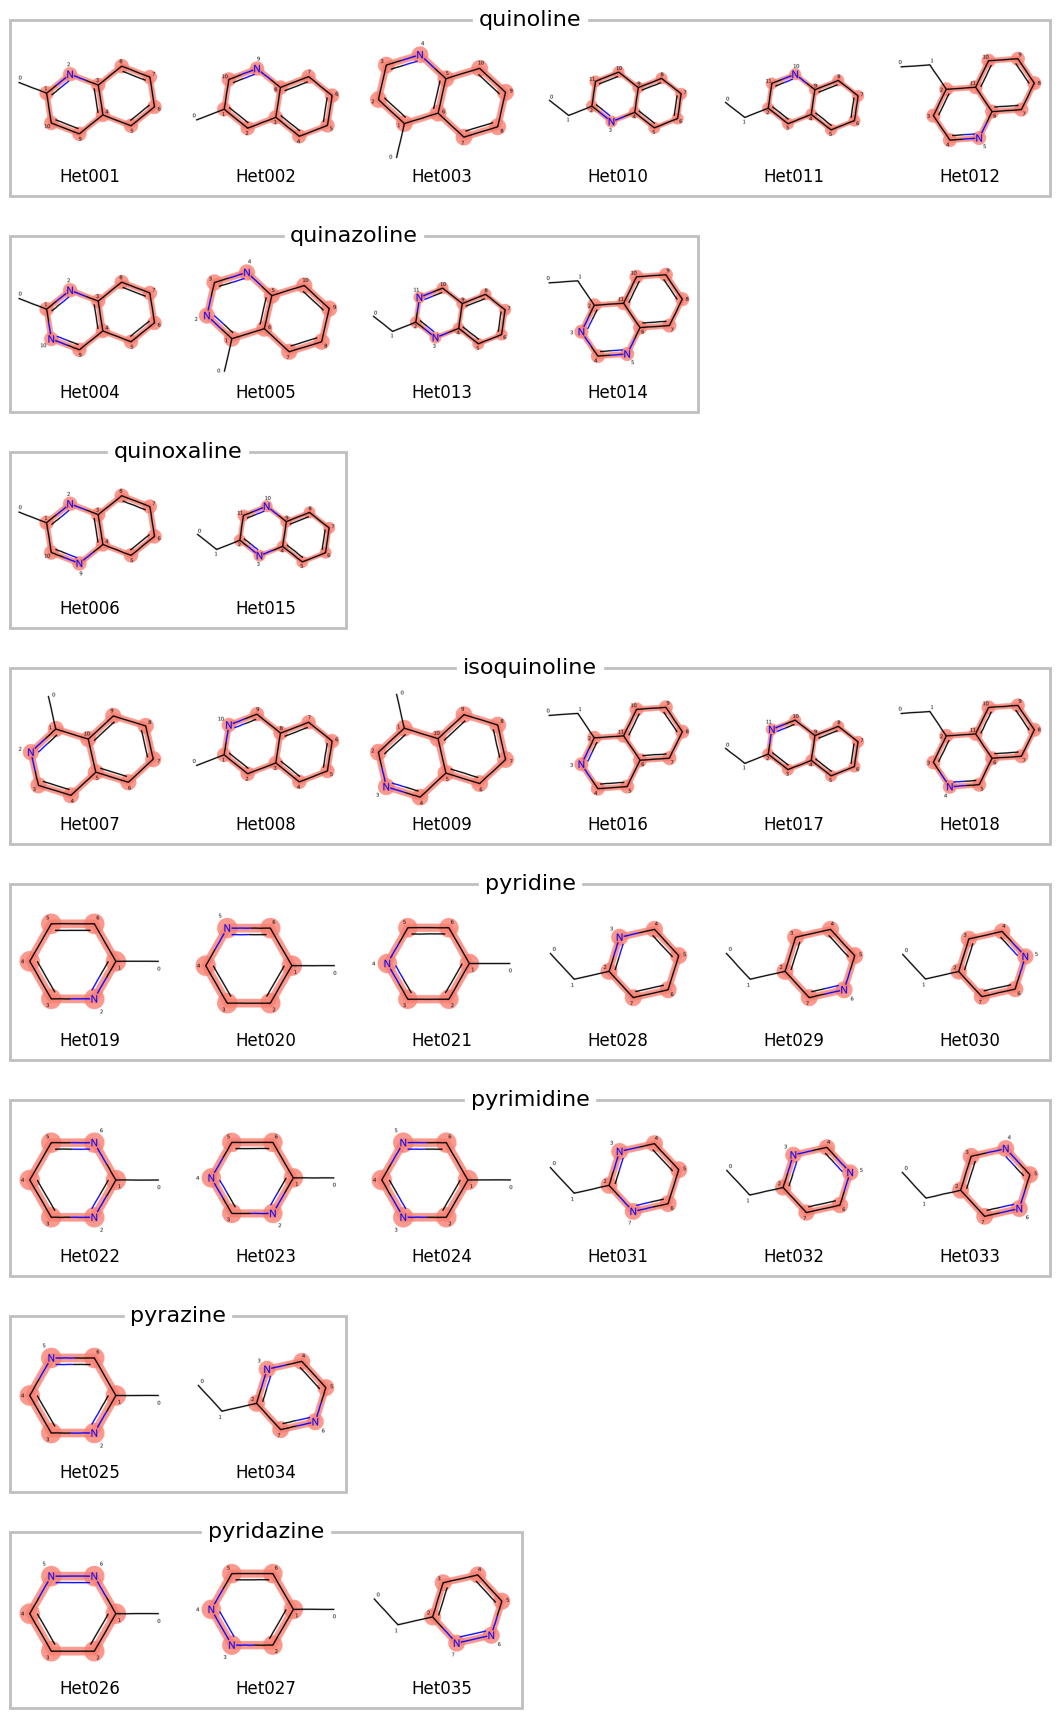

In [11]:
from matplotlib.patches import Rectangle

# Initialize figure
fig = plt.figure(figsize=(8, 8))
cols_per_group = 6  # Number of columns per group
image_size = 0.2  # Fraction of figure size for each image (normalized)
padding = 0.02  # Padding between images
group_gap = 0.05  # Gap between groups
current_bottom = -1.0  # Start from the top of the figure

for group, molecules in molsMatrix.items():
    group_images = []  # Store image paths for the group
    group_legend = legendsMatrix[group]
    num_images = len(molecules)
    num_rows = (
        num_images + cols_per_group - 1
    ) // cols_per_group  # Rows needed for the group

    # Calculate group box height
    group_height = num_rows * (image_size + padding)

    # Plot each molecule
    for idx, mol in enumerate(molecules):
        img_path = os.path.join(output_dir, f"{group}_{group_legend[idx]}.png")
        img = plt.imread(img_path)
        row = idx // cols_per_group
        col = idx % cols_per_group

        # Calculate the position of the molecule
        left = col * (image_size + padding) + padding
        bottom = current_bottom - (row + 1) * (image_size + padding)

        # Add image
        ax = fig.add_axes([left, bottom, image_size, image_size])
        ax.axis("off")
        ax.imshow(img)

        # Add caption for the molecule
        ax.text(
            0.5,
            0.02,
            group_legend[idx],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
            color=ColorConverter().to_rgba("black"),
            transform=ax.transAxes,
            antialiased=True,
            fontfamily="sans-serif",
        )

    # Draw a gray rectangle around the group
    group_width = min(cols_per_group, num_images) * (image_size + padding) - padding
    rect = Rectangle(
        (padding, current_bottom - group_height - padding),
        group_width,
        group_height,
        linewidth=2,
        edgecolor=ColorConverter().to_rgba("grey", alpha=0.5),
        facecolor="none",
        label=group,
    )
    fig.add_artist(rect)

    # Draw group label
    fig.text(
        x=0.5,
        y=1,
        s=group,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=16,
        color="black",
        transform=rect.get_transform(),
        backgroundcolor="white",
        fontfamily="sans-serif",
    )

    # Update the bottom position for the next group
    current_bottom -= group_height + group_gap

# Display the plot
plt.tight_layout()
plt.show()
# save the plot
fig.savefig(os.path.join(output_dir, "0.molecule_images.png"), dpi=600, bbox_inches="tight")

In [ ]:
# now step into to logs folder, rename the files to the new prefix
# the original file is named like Het001_conf-1.log
# the goal is to swap "Het001" to the new prefix pyrd and add a unique number to the end, in this case pyrd1
# maintain four counter starting from 1 for each prefix
# we will use the os module to rename the files

import os
import re
import shutil

final_mapping = {}

# create a new folder to store the renamed files
os.makedirs("renamed_logs", exist_ok=True)

# create a counter for each prefix
counter = {}
for key in common_structure_list.keys():
    counter[key] = 1
    
file_list = glob.glob("logs/*.log")
# sort the file list
file_list.sort()


# loop through the logs folder
for file in file_list:
    # get the filename without the extension
    filename = os.path.basename(file).split(".")[0]
    # get the prefix
    prefix = filename.split("-")[0]
    subprefix = prefix.split("_")[0]
    # store the other part of the filename
    other = filename.split("-")[1]
    # split by - get the first part, check against all key in the final_mapping
    if prefix in final_mapping:
        print(f"{prefix} already in final_mapping, will not overwrite")
        continue
    print(
        f"Processing {filename}, prefix: {prefix}, subprefix: {subprefix}, other: {other}"
    )

    # check if the subprefix is already in the final_mapping
    if subprefix not in final_mapping:
        new_filename = (
            mapping[subprefix]
            + str(counter[mapping[subprefix]])
            + "_conf-"
            + other
            + ".log"
        )
        # this mean we haven't assign a new number to this subprefix
        final_mapping[subprefix] = [new_filename]
        # increment the counter
        counter[mapping[subprefix]] += 1
    else:
        # now this subprefix is already assign a new number, we will reuse the number
        # note we will not use the counter and instead we will use regex to extract the number
        number = int(re.search(r"(\d+)_", final_mapping[subprefix][-1]).group(1))
        print(
            f"New number alreadu assigned: {number}, extract from {final_mapping[subprefix][-1]}"
        )
        new_filename = mapping[subprefix] + str(number) + "_conf-" + other + ".log"
        final_mapping[subprefix].append(new_filename)

    print(f"New filename: {new_filename}")
    print(f"Renaming {filename} to {new_filename}")
    if os.path.exists(f"renamed_logs/{new_filename}"):
        print(f"Warning: {new_filename} already exists, will overwrite")
    print("-----------------------------")
    # check if the file already exists in renamed_logs
    # copy the file with the new prefix to renamed_logs
    shutil.copy(file, f"renamed_logs/{new_filename}")

In [ ]:
final_mapping

In [9]:
# sort the final_mapping by the key, use the number in the prefix, format is Het008, split by Het and get the numerical part and turn it into integer
sorted_mapping = dict(
    sorted(final_mapping.items(), key=lambda x: int(x[0].split("Het")[1]))
)

In [ ]:
sorted_mapping

In [ ]:
mapping

In [ ]:
# inverse the mapping so that key is the new prefix and value is the original prefix, there are multiple same key in the mapping
inverse_mapping = {}
for key, value in mapping.items():
    if value in inverse_mapping:
        inverse_mapping[value].append(key)
    else:
        inverse_mapping[value] = [key]
        
inverse_mapping

In [ ]:
mols

In [ ]:
# display the molecules in a grid images group by the imverse_mapping key
for key, value in inverse_mapping.items():
    # get the molecules name
    print(f"Processing {key} with molecules {value}")
    mols_ = [mols[id] for id in value]
    legends_ = value
    
    # Generate a grid image with a fixed number of columns (4 columns)
    img = Chem.Draw.MolsToGridImage(
        mols_, molsPerRow=3, subImgSize=(150, 150), legends=legends_
    )
    # Display the grid of images
    display(img)

In [15]:
# output this to json
import json

with open("name_mapping.json", "w") as f:
    json.dump(final_mapping, f, sort_keys=True, indent=4)